In [5]:
import pandas as pd
import numpy as np

pathname='/Users/rishigummakonda/Documents/Springboard/capstone/data/census_tract/from_atlas/'
nyc = pd.read_csv(pathname+'nyc_tracts.csv')
la = pd.read_csv(pathname+'la_tracts.csv')
den = pd.read_csv(pathname+'denver_tracts.csv')
nash=pd.read_csv(pathname+'nashville_tracts.csv')
atlas = pd.read_csv('/Users/rishigummakonda/Documents/Springboard/capstone/data/atlas_data/atlas.csv')

In [6]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import seaborn as sns
from statsmodels.graphics.regressionplots import *
import statsmodels.api as sm
from statsmodels.formula.api import ols

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("paper")
%matplotlib inline

In [7]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

The codes in the 'tract' column within each dataset contain the state code, county, and tract code. The function below splits it up and creates a new dataframe. 

In [8]:
def split_codes(full_codes):
    state_codes=[]
    county_codes=[]
    tract_codes=[]
    for code in full_codes:
        code=str(code)
        state=int(code[:2])
        county=int(code[2:5])
        tract=int(code[5:11])
        state_codes.append(state)
        county_codes.append(county)
        tract_codes.append(tract)
    dict_codes = {'full_codes': full_codes, 'state':state_codes, 'county': county_codes, 'tract': tract_codes}
    df= pd.DataFrame(dict_codes)
    return df

The function below filters through the atlas dataset, finding the relevant tracts.

In [9]:
def filter_atlas(city_df):
    list_of_tracts=[]
    for index, row in city_df.iterrows():
        state_f = atlas[atlas['state'] == row['state']]
        county_f = state_f[state_f['county'] == row['county']]
        tract = county_f[county_f['tract'] == row['tract']] 
        list_of_tracts.append(tract)
    df = pd.concat(list_of_tracts,ignore_index=True)
    return df

Each dataset contains tracts which are not within the city lines. The next few code blocks are filtering those cities out and then splitting the codes up into state, county and tracts.

In [10]:
nyc_names =nyc["Name"]
new_nyc = nyc[nyc_names.str.contains("New York") | nyc_names.str.contains("Queens") 
              | nyc_names.str.contains("Bronx County")]
nyc_tracts = split_codes(list(new_nyc['tract']))
nyc_tracts.shape


(1291, 4)

In [11]:
la_names =la["Name"]
new_la = la[la_names.str.contains("Los Angeles")]
la_codes = list(new_la['tract'])
la_tracts=split_codes(la_codes)
la_tracts.shape

(1046, 4)

In [12]:
den_names =den["Name"]
new_den = den[den_names.str.contains("Denver")]
denver_codes=list(new_den['tract'])
denver_tracts=split_codes(denver_codes)
denver_tracts.shape

(168, 4)

In [13]:
nash_names =nash["Name"]
new_nash = nash[nash_names.str.contains("Nashville")]
nashville_codes=list(new_nash['tract'])
nashville_tracts=split_codes(nashville_codes)
nashville_tracts.shape

(154, 4)

In [14]:
all_tracts_df = pd.concat([nyc_tracts,la_tracts,denver_tracts,nashville_tracts], ignore_index=True)
all_tracts_df.shape

(2659, 4)

This creates new datasets from the atlas dataset.

In [15]:
nyc_atlas= filter_atlas(nyc_tracts)
la_atlas=filter_atlas(la_tracts)
den_atlas=filter_atlas(denver_tracts)
nash_atlas=filter_atlas(nashville_tracts)

In [52]:
la_atlas.head()

,tract,county,state,cz,czname,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,...,kfr_white_p25,kfr_white_p75,kfr_white_p100,count_pooled,count_white,count_black,count_asian,count_hisp,count_natam,mergecounts


Testing with NYC data: Do a train/test split, fit it to a linear regression model, then do one with k-fold cross validation and get the scores. then do a heatmap

In [49]:
cleaned_nyc = nyc_atlas.drop(['tract','county','state','cz','czname','mergecounts', 
                              'kfr_natam_p25', 'kfr_natam_p75','kfr_natam_p100','count_natam'],axis =1)
cleaned_nyc.fillna(0, inplace=True)

In [50]:
y= cleaned_nyc['kfr_pooled_p25']
X= cleaned_nyc.drop(['kfr_pooled_p25'],axis=1)

In [51]:
# Create training and test sets
X_train, X_test, y_train, y_test = tts(X, y, test_size = .3, random_state=42)

# Create the regressor: reg_all
reg_all = lr()

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mse(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.951756619589142
Root Mean Squared Error: 2255.466599798517


In [20]:
heatmap_data_nyc = nyc_atlas.drop(['tract','county','state','cz','czname','mergecounts', 
                                   'kfr_natam_p25', 'kfr_natam_p75','kfr_natam_p100','count_natam',],axis =1)


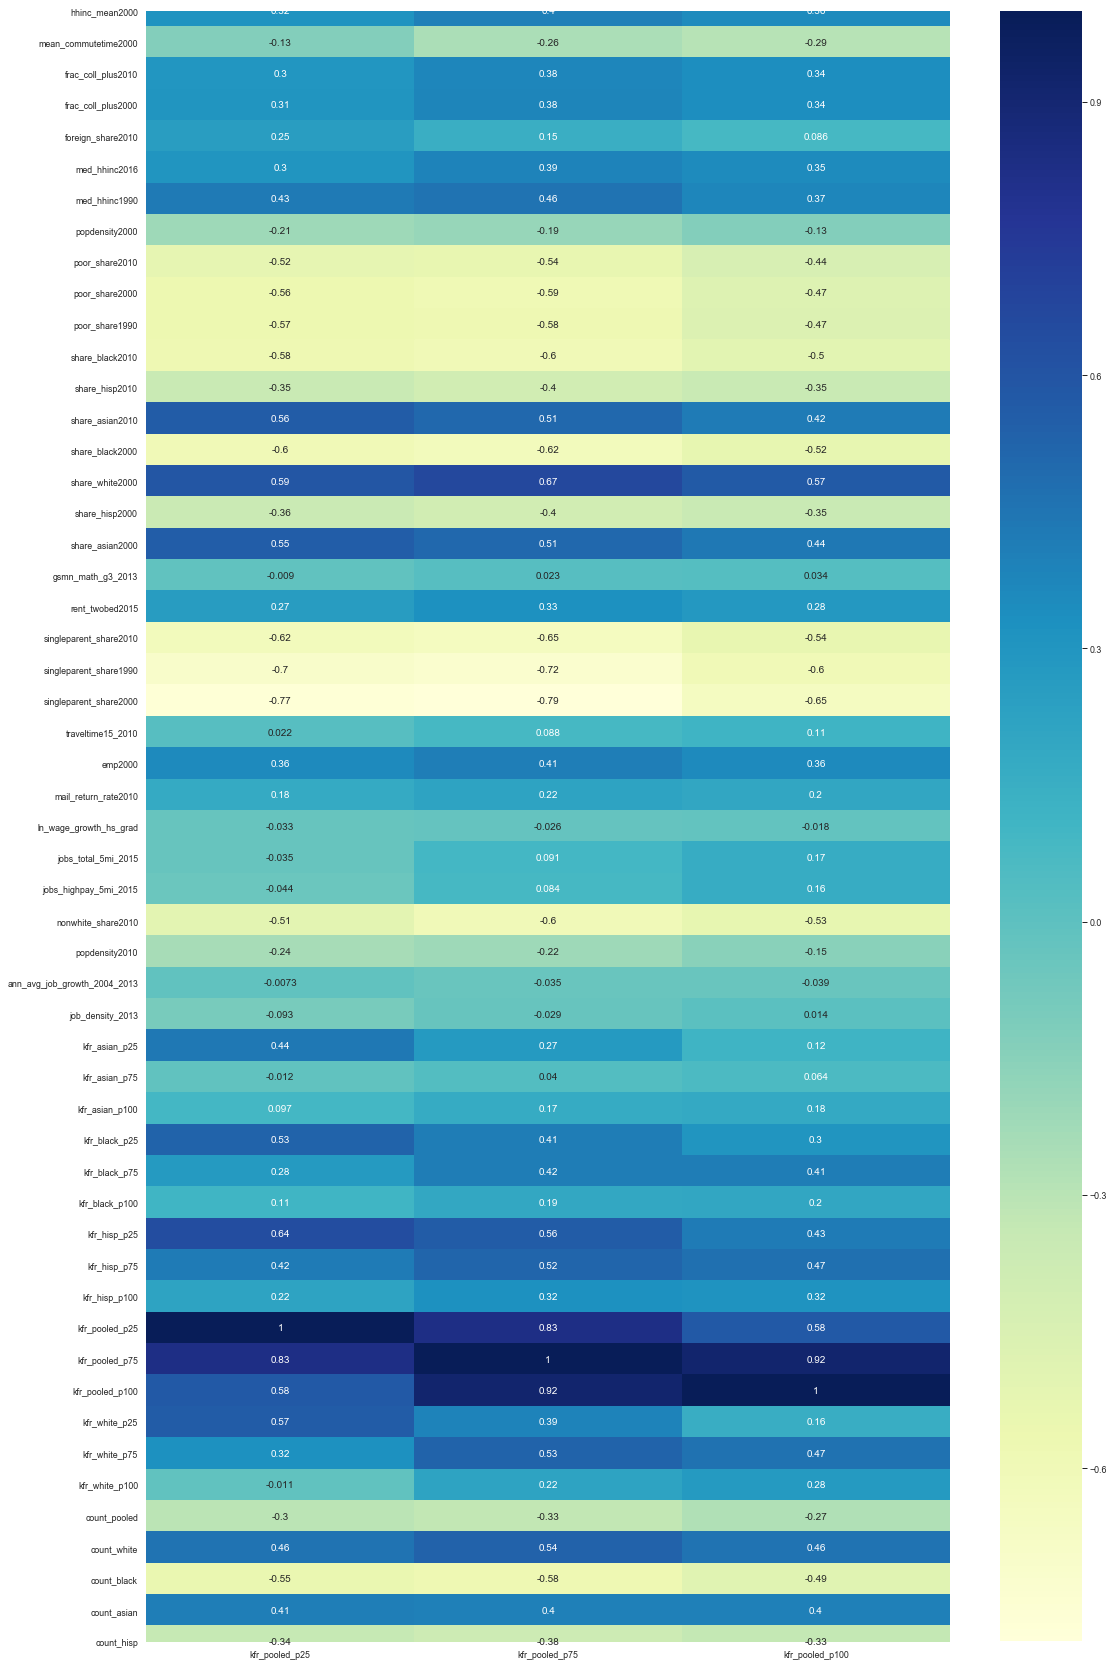

In [21]:
plt.figure(figsize=(18,30))
sns.heatmap(heatmap_data_nyc.corr()[['kfr_pooled_p25','kfr_pooled_p75','kfr_pooled_p100']], annot=True, cmap="YlGnBu")

In [22]:
def weighted_avg(city_df, col_name):    
    city_df.fillna(0,inplace=True)
    running_total =0
    for index, row in city_df.iterrows():
        weight = row[col_name]*row['count_pooled']
        running_total+=weight
    weighted_avg= running_total/sum(city_df['count_pooled'])
    return weighted_avg

In [23]:
weighted_avg(nyc_atlas,'kfr_pooled_p25')

35175.238344771635

In [24]:
def find_state(state_code):
    atlas.dropna()
    return atlas[atlas['state']==state_code]

In [25]:
find_state(36)

,tract,county,state,cz,czname,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,...,kfr_white_p25,kfr_white_p75,kfr_white_p100,count_pooled,count_white,count_black,count_asian,count_hisp,count_natam,mergecounts
42874,100,1,36,18600.0,Albany,50391.891,19.435076,0.093633,0.115219,0.136915,...,27379.680,38937.078,50294.129,498.0,109.0,308.0,12.0,39.0,0.0,matched (3)
42875,200,1,36,18600.0,Albany,40015.555,23.676914,0.147101,0.126274,0.098438,...,34357.434,59064.988,89893.820,1900.0,48.0,1540.0,31.0,203.0,1.0,matched (3)
42876,300,1,36,18600.0,Albany,63757.352,20.868145,0.215100,0.182538,0.078504,...,32514.145,50474.898,70966.219,1445.0,451.0,737.0,38.0,141.0,3.0,matched (3)
42877,401,1,36,18600.0,Albany,85420.609,21.597206,0.430931,0.371955,0.097241,...,28199.760,56112.887,93340.719,191.0,124.0,33.0,10.0,19.0,0.0,matched (3)
42878,403,1,36,18600.0,Albany,74094.234,18.898617,0.601896,0.498365,0.209118,...,55511.813,63248.313,70438.281,685.0,504.0,89.0,23.0,30.0,1.0,matched (3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47728,150100,123,36,18000.0,Buffalo,60764.992,24.871489,0.211260,0.168255,0.020542,...,39115.852,54060.406,70198.375,1680.0,1608.0,17.0,10.0,24.0,1.0,matched (3)
47729,150200,123,36,18000.0,Buffalo,57921.156,22.217421,0.164481,0.139244,0.009833,...,37833.730,54783.840,73647.047,1481.0,1427.0,3.0,7.0,12.0,4.0,matched (3)
47730,150300,123,36,18000.0,Buffalo,67415.531,31.940084,0.175843,0.174154,0.027891,...,35326.188,52847.328,72643.563,1436.0,1394.0,7.0,3.0,14.0,2.0,matched (3)
47731,150400,123,36,18000.0,Buffalo,71483.492,20.090122,0.340824,0.285352,0.020073,...,36837.418,53671.594,72437.492,775.0,757.0,2.0,4.0,4.0,1.0,matched (3)


In [26]:
def find_county(state_code,county_code):
    atlas.fillna(0,inplace=True)
    state = atlas[atlas['state']== state_code]
    return state[state['county'] == county_code]

In [27]:
find_county(36,61)

,tract,county,state,cz,czname,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,...,kfr_white_p25,kfr_white_p75,kfr_white_p100,count_pooled,count_white,count_black,count_asian,count_hisp,count_natam,mergecounts
45230,201,61,36,19400.0,New York,43571.824,37.127106,0.158639,0.138534,0.454364,...,0.000,0.000,0.000,813.0,12.0,96.0,291.0,393.0,2.0,matched (3)
45231,202,61,36,19400.0,New York,48836.855,38.877193,0.242855,0.205191,0.224750,...,30068.887,57642.988,94115.094,1358.0,222.0,186.0,260.0,652.0,0.0,matched (3)
45232,500,61,36,19400.0,New York,0.000,0.000000,0.000000,0.000000,0.000000,...,11223.441,56542.367,163216.090,0.0,0.0,0.0,0.0,0.0,0.0,matched (3)
45233,600,61,36,19400.0,New York,42727.797,36.415771,0.137340,0.101212,0.601802,...,39271.461,61219.328,87014.063,2564.0,48.0,286.0,1462.0,698.0,7.0,matched (3)
45234,700,61,36,19400.0,New York,142697.800,21.555222,0.809285,0.736985,0.311308,...,30332.287,55265.430,86847.969,36.0,21.0,3.0,1.0,11.0,0.0,matched (3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45510,30900,61,36,19400.0,New York,50557.906,49.650925,0.182698,0.151082,0.344635,...,32427.756,52411.898,75910.977,2305.0,78.0,529.0,36.0,1617.0,8.0,matched (3)
45511,31100,61,36,19400.0,New York,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000,0.000,3.0,0.0,3.0,0.0,0.0,0.0,matched (3)
45512,31703,61,36,19400.0,New York,195213.020,26.337315,0.844499,0.754871,0.316874,...,57779.570,60805.125,63479.203,668.0,439.0,21.0,123.0,48.0,1.0,matched (3)
45513,31704,61,36,19400.0,New York,195213.020,26.337313,0.814636,0.754871,0.407541,...,30697.662,52547.668,78988.555,492.0,323.0,16.0,90.0,35.0,0.0,matched (3)


In [28]:
def weighted_std(city_df, col_name):
    city_df.dropna()
    top = 0
    mean = weighted_avg(city_df,col_name)
    for index, row in city_df.iterrows():
        top=top+((row[col_name]-mean)**2)
    return np.sqrt(top/sum(city_df['count_pooled']))

In [29]:
weighted_std(find_county(36,61),'kfr_pooled_p25')

326.14913071362935

In [39]:
np.average(cleaned_nyc['kfr_pooled_p25'], weights = cleaned_nyc['count_pooled'])

35175.238344771635

In [36]:
cleaned_nyc['count_pooled'].shape

(1283,)

In [37]:
cleaned_nyc['kfr_pooled_p25'].shape

(1283,)

In [1]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))